# Vehicle Detection Project

This is an exploration notebook. The goals are:

* Train a HoG-based car classifier
* Extensively study parameter settings

---

---
# Train HoG-based car classifier

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time

import os
import pandas as pd

In [2]:
from util import read_images, convert_color, plotList

In [3]:
from classifier import Classifier

# Features

In [4]:
from features import prepare_train_test, get_hog_features, bin_spatial, color_hist, single_img_features, extract_features

## Dataset preparations

#### Experiment with a smaller subset

In [5]:
cars    = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/non-vehicles/**/*.png')

# Reduce the sample size because HOG features are slow to compute
sample_size  = -1                                                    # note, I know using -1 removes the last element, but it makes ilfe easier
cars         = cars[0:sample_size]
notcars      = notcars[0:sample_size]
cars_imgs    = read_images(cars)
notcars_imgs = read_images(notcars)

print('#cars    ', len(cars))
print('#notcars ', len(notcars))

#cars     8791
#notcars  8967


## Model training and parameter tuning

We start with the suggested initial parameters from the classroom.

By fixating most parameters and varying a small subset we can get a feeling for how these parameters behave.

In order to train a classifier we demonstrate the training pipeline.

In [6]:
def defaults():
     return {
        'color_space':    'RGB',    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        'hist_bins':      32,       # Number of histogram bins
        'spatial_size':   (32,32),  # Spatial binning dimensions
        'orient':         9,        # HOG orientations
        'hog_channel':    0,        # Can be 0, 1, 2, or "ALL"
        'pix_per_cell':   8,        # HOG pixels per cell
        'cell_per_block': 2,        # HOG cells per block
        'spatial_feat':   False,    # Spatial features on or off
        'hist_feat':      False,    # Histogram features on or off
        'hog_feat':       False      # HOG features on or off
    }

config = defaults()

y_start_stop   = [400, 656]     # Min and max in y to search in slide_window()

In [8]:
config['hog_feat'] = True
X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs)

print('train', X_train.shape, y_train.shape)
print('test', X_test.shape,  y_test.shape)
print('Feature vector length:', len(X_train[0]))

train (14206, 1764) (14206,)
test (3552, 1764) (3552,)
Feature vector length: 1764


##### Discussion:

The feature length is 1764. The final feature length will vary with parameter tuning.

More features means more computational cost. Ideally we keep fewer, but more significant features. More features, however, can be justified if we get significantly higher accuracy in return.

Let's try to at improve accuracy while feature length remains the same. If we can significantly improve the accuracy, let's not more than double the feature length. So a ballpark figure of at most 3500 features, but ideally somwhere around 2000, preferably less.

---

#### Compare classifier types

In [9]:
classifier, t_s = Classifier('decision_tree').train(X_train, y_train)
print('{} seconds to train decision tree... Accuracy = {:.4f}'.format(t_s, classifier.score(X_test, y_test)))

classifier, t_s = Classifier('linear_svm').train(X_train, y_train)
print('{} seconds to train linear svm... Accuracy = {:.4f}'.format(t_s, classifier.score(X_test, y_test)))

classifier, t_s = Classifier('nonlinear_svm').train(X_train, y_train)
print('{} seconds to train nonlinear svm... Accuracy = {:.4f}'.format(t_s, classifier.score(X_test, y_test)))

46.58 seconds to train decision tree... Accuracy = 0.8609
28.39 seconds to train linear svm... Accuracy = 0.9023
100.19 seconds to train nonlinear svm... Accuracy = 0.9203


##### Discussion:

Typically linear SVMs outperform decision trees and non-linear SVMs outperform linear SVMs.

For simplicity and speed, we will use the popular and robust linear SVM for parameter and model selection.

For the final classifier, however, we will simply train a nonlinear SVM.

Note, this experiment gives as a baseline SVM for HoG features of 93.5%. Will try to remember this number.

---

### Color Histogram Features

In [10]:
print('Testing histogram features with varying color spaces and histogram bins\n')

config = defaults()
config['spatial_feat'] = False
config['hist_feat']    = True
config['hog_feat']     = False

colors = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
bins   = [8,16,32,64,128,256]

N = len(colors)
M = len(bins)

data = np.array( [''] * (N+1) * (M+1), dtype=np.object ).reshape( (M+1, N+1) )

for j in range(N):
    data[0,j+1] = colors[j]
for i in range(M):
    data[i+1,0] = str(bins[i])

for j,color in enumerate(colors):
    for i,num_bins in enumerate(bins):
        
        config['color_space'] = color
        config['hist_bins']   = num_bins
        X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs, 0)
        classifier, t_s = Classifier('linear_svm').train(X_train, y_train)
        accuracy = round(classifier.score(X_test, y_test), 4)
        
        data[i+1,j+1] = str(accuracy)

print(pd.DataFrame(data=data[1:,1:], index=data[1:,0], columns=data[0,1:]))

Testing histogram features with varying color spaces and histogram bins

        RGB     HSV     LUV     HLS     YUV   YCrCb
8    0.8421  0.8744  0.7872  0.8891  0.8609  0.8711
16   0.8888  0.8964  0.8347  0.9032  0.8843  0.8865
32   0.9147  0.9299  0.9079   0.931  0.9051  0.9017
64    0.922  0.9485  0.9229  0.9451  0.9153  0.9161
128  0.9291  0.9581  0.9485  0.9527  0.9234  0.9288
256  0.9158  0.9592  0.9459  0.9578  0.9268  0.9243


##### Discussion:

Color histogram binning works better in HSV and HLS space. In these spaces more bins typically increase performance, as would be expected. This isn't always the case in other spaces, indicating some form of non-linearity.

I would say the results start to converge and the increased feature length at some point doesn't pay off anymore. I would suggest a maximum of 128 features.

It is a surprising result: We achieve above 95% accuracy with simple color binning features. This is an improvement over HoG with a linear SVM baseline of around 93.5%.

We should consider whether the dataset is maybe too simple. Basically, the classifier learns "vehicles have colors, othre things don't". This might be correct in the majority of scenery, but it is obvious that this rule of thumb is not always true. A clear case of learning the wrong thing and overfitting.

### Spatial Features

In [11]:
print('Testing spatial features\n')

config = defaults()
config['spatial_feat'] = True
config['hist_feat']    = False
config['hog_feat']     = False


color_space    = 'RGB'
orient         = 9    # HOG orientations
pix_per_cell   = 8    # HOG pixels per cell
cell_per_block = 2    # HOG cells per block
hog_channel    = 0    # Can be 0, 1, 2, or "ALL"

variables = [2, 4, 8, 16, 32, 64]

N = len(variables)

data = np.array( [''] * (N+1) * (4), dtype=np.object ).reshape( (4, N+1) )
data[1,0] = 'accuracy %'
data[2,0] = 'speed (sec)'
data[3,0] = '# features'


for j in range(N):
    data[0,j+1] = variables[j]

for j,variable in enumerate(variables):
    
    t1 = time.time()
    
    config['spatial_size'] = (variable, variable)
    X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs, 0)
    classifier, t_s = Classifier('linear_svm').train(X_train, y_train)
    
    t2 = time.time()
    
    data[1,j+1] = round(classifier.score(X_test, y_test), 4)*100
    data[2,j+1] = '{:.2f}'.format(t2-t1)
    data[3,j+1] = len(X_train[0])

print(pd.DataFrame(data=data[1:,1:], index=data[1:,0], columns=data[0,1:]))

Testing spatial features

                2      4      8      16     32      64
accuracy %   76.38  81.11  90.68  92.37  91.16   90.82
speed (sec)   1.57   3.37   6.30  13.08  37.62  124.49
# features      12     48    192    768   3072   12288


##### Discussion:

A setting of (16,16) for spatial_size achieves the highest accuracy. Relatively (if you compare to HoG) few features and reasonable speed. This is the recommended setting.

---

### HoG Features

HoG offers multiple parameters. The main strategy we follow here is to change a parameter at a time and see how that affects results. This ignores parameter inter-dependencies, so we try to be a little bit more smart here.

Initially we vary color spaces. Note, we can choose which color channel HoG uses or if it is supposed to use all channels. These parameters are related, so we look at them together.

Thereafter, we look at number of orientation bins, pixels per cell and cells per block individually.

In [12]:
print('Testing HoG features with varying hog channels\n')

config = defaults()
config['spatial_feat'] = False
config['hist_feat']    = False
config['hog_feat']     = True

color_space    = 'RGB'
orient         = 9    # HOG orientations
pix_per_cell   = 8    # HOG pixels per cell
cell_per_block = 2    # HOG cells per block
hog_channel    = 0    # Can be 0, 1, 2, or "ALL"

colors = ['RGB', 'HSV', 'HLS', 'LUV', 'YUV', 'YCrCb']
variables = [0, 1, 2, 'ALL']

N = len(colors)
M = len(variables)
data = np.array( [''] * (N+1) * (M+1), dtype=np.object ).reshape( (M+1, N+1) )

for j in range(N):
    data[0,j+1] = colors[j]
for i in range(M):
    data[i+1,0] = str(variables[i])

for j,color in enumerate(colors):
    for i,variable in enumerate(variables):
        color_space = color
        hog_channel = variable
        
        config['color_space'] = color
        config['hog_channel'] = variable
        
        try:
            X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs, 0)
            classifier, t_s = Classifier('linear_svm').train(X_train, y_train)
            accuracy = round(classifier.score(X_test, y_test), 4)
        except:
            accuracy = 0
        
        data[i+1,j+1] = accuracy

print(pd.DataFrame(data=data[1:,1:], index=data[1:,0], columns=data[0,1:]))

Testing HoG features with varying hog channels



/Users/edo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
/Users/edo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:17: RuntimeWarning: invalid value encountered in minimum
  out = np.minimum(out, 0.2)
/Users/edo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/numpy/lib/function_base.py:1763: RuntimeWarning: invalid value encountered in subtract
  out[slice1] = (f[slice4] - f[slice2]) / (2. * dx[i])
/Users/edo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/numpy/lib/function_base.py:1791: RuntimeWarning: invalid value encountered in subtract
  out[slice1] = (y[slice2] - y[slice3]) / dx_n
/Users/edo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/numpy/lib/function_base.py:1784: RuntimeWarning: invalid value encountered in subtract
  out[slice1] = (y[slice2] - y[slice3]) / dx_0
/Users/edo/anaconda/envs/carnd-term1/lib/python3.5/

        RGB     HSV     HLS     LUV     YUV   YCrCb
0    0.8922  0.9009  0.9015  0.9167  0.9122  0.9161
1    0.9102   0.906  0.9122       0       0       0
2    0.9051  0.9113       0       0       0       0
ALL  0.9195  0.9524       0       0       0       0


##### Discussion:

It looks as tho LUV, YUV and YCrCb colorspaces are more convenient for HoG features if we use the first channel only. I think it makes sense for YUV and YCrCb, where we have a separate channel for luminance and luminance/edges is what gradient features highlight. Not sure about how LUV is composed and whether the L channel can be considered a luminance plane.

With the knowledge that color binning features worked well in HSV and HLS space, it is unfortunate that HSV and HLS appear to be less convenient for HoG. However, converting to HSV still improves HoG over using RGB.

An interesting result is that usnig all channels outperforms individual color channels. This is great as HSV becomes interesting again. With this in mind, we will have to decide whether we can expense the computational effort, since using all channels triples the feature vector size.

In order to continue comparing though, we will use RGB as the baseline color space.

In [13]:
print('Testing HoG features with varying orientations\n')

config = defaults()
config['spatial_feat'] = False
config['hist_feat']    = False
config['hog_feat']     = True

color_space    = 'RGB'
orient         = 9    # HOG orientations
pix_per_cell   = 8    # HOG pixels per cell
cell_per_block = 2    # HOG cells per block
hog_channel    = 0    # Can be 0, 1, 2, or "ALL"

variables = [4,8,9,16,32,64,128]

N = len(variables)

data = np.array( [''] * (N+1) * (5), dtype=np.object ).reshape( (5, N+1) )
data[1,0] = 'accuracy %'
data[2,0] = '# features'
data[3,0] = 'feat. speed'
data[4,0] = 'train speed'

for j in range(N):
    data[0,j+1] = variables[j]

for j,variable in enumerate(variables):
    
    config['orient'] = variable
    
    t1 = time.time()
    X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs, 0)
    t2 = time.time()
    
    classifier, t_s = Classifier('linear_svm').train(X_train, y_train)
    
    data[1,j+1] = round(classifier.score(X_test, y_test), 4) * 100
    data[2,j+1] = len(X_train[0])
    data[3,j+1] = '{:.2f}'.format(t2-t1)
    data[4,j+1] = '{:.2f}'.format(t_s)

print(pd.DataFrame(data=data[1:,1:], index=data[1:,0], columns=data[0,1:]))

Testing HoG features with varying orientations

               4      8      9      16     32      64      128
accuracy %   90.29  90.37  88.99  89.53  90.79   91.08   92.57
# features     784   1568   1764   3136   6272   12544   25088
feat. speed  28.04  30.40  31.96  33.14  41.89   56.82  137.17
train speed  14.35  19.41  21.73  21.63  44.19  108.67  258.13


##### Discussion:

The number of orientations changes how coarse or fine the gradient orientation bins are.

We observe that an increase in number of orientation bins linearly goes hand in hand with an improvement in accuracy.
This indicates that larger vectors are more expressive, since smaller bins are a reduction of information.
However, as the feature size increases, feature extraction speed increases, too.

If we had enough computational power we might want to use even more than 128 features. Looking at feature sizes, 25088 dimensional features, howver, sounds a fair bit obscene. In my experience, in real-time applications 64 dimensional vectors would be popular due to efficient hamming distance computation. Also, we have previously aimed at a ballpark figure of 2000 features...

For now the conclusion is: If we have more computational power available (for example due to saving speed elsewhere, or by reducing the feature size through other parameters), then we can improve accuracy by increasing the orientation bins.

---

In [14]:
print('Testing HoG features with varying pixels per cell\n')

config = defaults()
config['spatial_feat'] = False
config['hist_feat']    = False
config['hog_feat']     = True

variables = [4,8,16,32]

N = len(variables)

data = np.array( [''] * (N+1) * (4), dtype=np.object ).reshape( (4, N+1) )
data[1,0] = 'accuracy %'
data[2,0] = 'speed (sec)'
data[3,0] = '# features'

for j in range(N):
    data[0,j+1] = variables[j]

for j,variable in enumerate(variables):
    pix_per_cell = variable
    
    config['pix_per_cell']     = variable

    t1 = time.time()
    X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs, 0)
    t2 = time.time()
    
    classifier, t_s = Classifier('linear_svm').train(X_train, y_train)
    data[1,j+1] = round(classifier.score(X_test, y_test), 4)*100
    data[2,j+1] = '{:.2f}'.format(t2-t1)
    data[3,j+1] = len(X_train[0])

print(pd.DataFrame(data=data[1:,1:], index=data[1:,0], columns=data[0,1:]))

Testing HoG features with varying pixels per cell

                 4      8      16    32
accuracy %    86.12  89.02   93.3  86.4
speed (sec)  113.66  29.99  13.31  9.15
# features     8100   1764    324    36


##### Discussion:

In this dataset we can see that a small number of this parameter leads to longer feature vectors. Luckily we can increase to 16 and get an even better result with more than 5 times less features. This will give much room to improve the classifier through other means, such as using more orientation bins.

---

In [15]:
print('Testing HoG features with varying cells per block\n')

config = defaults()
config['spatial_feat'] = False
config['hist_feat']    = False
config['hog_feat']     = True

variables = [1,2,3,4,5,6,8,9,16]

N = len(variables)

data = np.array( [''] * (N+1) * (4), dtype=np.object ).reshape( (4, N+1) )
data[1,0] = 'accuracy %'
data[2,0] = 'speed (sec)'
data[3,0] = '# features'


for j in range(N):
    data[0,j+1] = variables[j]

for j,variable in enumerate(variables):
    t1 = time.time()
    
    config['cell_per_block'] = variable

    try:
        X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs, 0)
        classifier, t_s = Classifier('linear_svm').train(X_train, y_train)
        accuracy = round(classifier.score(X_test, y_test), 4)*100
    except:
        accuracy = 0
    
    t2 = time.time()
    
    data[1,j+1] = accuracy
    data[2,j+1] = '{:.2f}'.format(t2-t1)
    data[3,j+1] = len(X_train[0])

print(pd.DataFrame(data=data[1:,1:], index=data[1:,0], columns=data[0,1:]))

Testing HoG features with varying cells per block

                1      2      3      4      5      6      8     9     16
accuracy %   86.37  89.13  92.31  93.55  93.61  93.47   92.6     0     0
speed (sec)  44.61  53.96  56.04  52.79  50.93  50.56  21.37  9.10  0.00
# features     576   1764   2916   3600   3600   2916    576   576   576


##### Discussion:

This parameter appears to have non-linear properties in terms of feature length. This is poorly understood. Using values larger than 8 also leads to exceptions.

The experiment shows: We can get really tiny improvements of 0.5% at the expense of approximately doubling feature length. I don't think that is a reasonable choice.

We should consider varying this value together with the optimized values to see if it really makes a difference. If it doesn't, we should pick the value that gives us the smallest feature vector.


---

### Single channel vs. multi channel

The next experiment is trying to answer the following question: Should we reduce our feature configuration and use ALL channels or should we maximize the feature length and use a single channel only?

There are multiple parameters that affect the feature vector length. We won a bit of space since we set pix_per_cell=16, so we can increase the orientation bins and vary cells per block between 1,2 and 4.

We use HSV color space, because it has shown the maximum potential. While HSV is not ideal for the single channel HoG features, using the V channel had a comparable accuracy to the individual RGB channels. I acknowledge this is a minor bias towards ALL features, but I consider it negligible.

We will try to keep the feature length around 2000 features. For single-channel configurations we use the green channel, which previously had shown slightly better results.

---

In [32]:
print('Comparing smaller HoG features on ALL channels vs. longer HoG features on single channel\n')

config = defaults()
config['spatial_feat'] = False
config['hist_feat']    = False
config['hog_feat']     = True

configurations =  [
    ('HSV', 128, 2, 16, 1), ('HSV', 32, 'ALL', 16, 1), ('HSV', 16, 'ALL', 16, 1), ('HSV', 8, 'ALL', 16, 1), ('HSV', 4, 'ALL', 16, 1),
    ('HSV',  64, 2, 16, 2), ('HSV', 32, 'ALL', 16, 2), ('HSV', 16, 'ALL', 16, 2), ('HSV', 8, 'ALL', 16, 2), ('HSV', 4, 'ALL', 16, 2),
    ('HSV', 128, 2, 16, 4), ('HSV', 32, 'ALL', 16, 4), ('HSV', 16, 'ALL', 16, 4), ('HSV', 8, 'ALL', 16, 4), ('HSV', 4, 'ALL', 16, 4),
    ('HSV', 12, 'ALL', 16, 2), ('HSV', 11, 'ALL', 16, 2), ('HSV', 10, 'ALL', 16, 2), ('HSV', 9, 'ALL', 16, 2),
]

for c in configurations:
    config['color_space'], config['orient'], config['hog_channel'], config['pix_per_cell'], config['cell_per_block'] = c
    
    X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs, 0)
    classifier, t_s = Classifier('linear_svm').train(X_train, y_train)
    accuracy = round(classifier.score(X_test, y_test), 4)
    print('orientations: {}, channel: {}, cell_per_block: {}, accuracy: {:.2f}% ({} features)'.format(
        config['orient'], config['hog_channel'], config['cell_per_block'], accuracy*100, len(X_train[0]))
    )

Comparing smaller HoG features on ALL channels vs. longer HoG features on single channel

orientations: 128, channel: 2, cell_per_block: 1, accuracy: 91.27% (2048 features)
orientations: 32, channel: ALL, cell_per_block: 1, accuracy: 95.33% (1536 features)
orientations: 16, channel: ALL, cell_per_block: 1, accuracy: 96.51% (768 features)
orientations: 8, channel: ALL, cell_per_block: 1, accuracy: 96.23% (384 features)
orientations: 4, channel: ALL, cell_per_block: 1, accuracy: 93.95% (192 features)
orientations: 64, channel: 2, cell_per_block: 2, accuracy: 92.79% (2304 features)
orientations: 32, channel: ALL, cell_per_block: 2, accuracy: 96.17% (3456 features)
orientations: 16, channel: ALL, cell_per_block: 2, accuracy: 96.62% (1728 features)
orientations: 8, channel: ALL, cell_per_block: 2, accuracy: 96.85% (864 features)
orientations: 4, channel: ALL, cell_per_block: 2, accuracy: 95.69% (432 features)
orientations: 128, channel: 2, cell_per_block: 4, accuracy: 92.09% (2048 features)

##### Discussion:

The results confirm that using all channels typically outperforms a similarly configured feature vector of similar size that uses only a single channel.

We can actually use a smaller feature vector and achieve higher accuracy - great.

At the time of this writing the highest ranking configuration is as follows:


```
color space: HSV, orientations: 10, channel: ALL, cell_per_block: 2, accuracy: 97.10% (1080 features)
color space: HSV, orientations: 9, channel: ALL, cell_per_block: 2, accuracy: 96.96% (972 features)
color space: HSV, orientations: 8, channel: ALL, cell_per_block: 2, accuracy: 96.85% (864 features)
```

I also find the following configuration interesting, which has rather few features and still achieves an accuracy above 96%:

```
color space: HSV, orientations: 8, channel: ALL, cell_per_block: 4, accuracy: 96.57% (384 features)
```

After a change of heart I will now optimise a little bit towards smaller feature lengths and chose this latter configuration.

---

### Combining Features

Now we have optimal configurations for each type of feature.

The last question is if and how combining the features into a single feature vector yields better results.

While we're at it, we also use nonlinear SVMs to maximize classifier performance. This serves as our final comparison.

---

In [32]:
# These are the tweaked parameters

config_opt = {
    'color_space':    'HSV',    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'hist_bins':      8,        # Number of histogram bins
    'spatial_size':   (4,4),    # Spatial binning dimensions
    'orient':         8,        # HOG orientations
    'hog_channel':    'ALL',    # Can be 0, 1, 2, or "ALL"
    'pix_per_cell':   16,       # HOG pixels per cell
    'cell_per_block': 4,        # HOG cells per block
    'spatial_feat':   False,    # Spatial features on or off
    'hist_feat':      True,     # Histogram features on or off
    'hog_feat':       True      # HOG features on or off
}

In [27]:
print('Comparing feature combinations\n')

config = config_opt
configurations =  [
    ('color             ', True,  False, False),
    ('spatial           ', False, True,  False),
    ('hog               ', False, False, True),
    ('hog+spatial       ', False, True,  True),
    ('hog+color         ', True,  False, True),
    ('hog+color+spatial ', True,  True,  True),
]

for c in configurations:
    
    name, config['hist_feat'], config['spatial_feat'], config['hog_feat'] = c
    
    X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs, 0)
    classifier, t_s = Classifier('nonlinear_svm').train(X_train, y_train)
    accuracy = classifier.score(X_test, y_test)
    print('{}:\t {:.2f}% ({} features)'.format(name, accuracy*100, len(X_train[0])))

Comparing feature combinations

color             :	 97.58% (24 features)
spatial           :	 95.83% (48 features)
hog               :	 98.09% (384 features)
hog+spatial       :	 98.93% (432 features)
hog+color         :	 99.24% (408 features)
hog+color+spatial :	 99.35% (456 features)


##### Discussion / Summary:

Yes, combining features improves upon the individual baseline accuracy.

We managed to improve HoG baseline from around 92% to 98%.

A combined classifier gives accuracy in the 99% range.

---

In [38]:
print('Comparing fixed HoG with varying color features and varying spatial features\n')

config = config_opt
configurations =  [
(64, 4), (128, 4), (256, 4),
(64, 8), (128, 8), (256, 8),
(64, 16), (128, 16), (256, 16),
]

config['spatial_feat'] = True
config['hist_feat']    = True
config['hog_feat']     = True


for c in configurations:
    
    config['hist_bins'], spat = c
    config['spatial_size'] = (spat, spat)
    
    name = 'hog + color = {} + spatial = ({},{})'.format(config['hist_bins'], spat, spat)
    
    X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs, 0)
    classifier, t_s = Classifier('nonlinear_svm').train(X_train, y_train)
    accuracy = classifier.score(X_test, y_test)
    print('{}:\t {:.2f}% ({} features)'.format(name, accuracy*100, len(X_train[0])))

Comparing fixed HoG with varying color features and varying spatial features

hog + color = 64 + spatial = (4,4):	 99.47% (624 features)
hog + color = 128 + spatial = (4,4):	 99.61% (816 features)
hog + color = 256 + spatial = (4,4):	 99.61% (1200 features)
hog + color = 64 + spatial = (8,8):	 99.55% (768 features)
hog + color = 128 + spatial = (8,8):	 99.66% (960 features)
hog + color = 256 + spatial = (8,8):	 99.75% (1344 features)
hog + color = 64 + spatial = (16,16):	 99.61% (1344 features)
hog + color = 128 + spatial = (16,16):	 99.61% (1536 features)
hog + color = 256 + spatial = (16,16):	 99.77% (1920 features)


I'm going to choose the configuration with 960 features, because I think it achieves third-best accuracy and still has less than a thousand (arbitrary choice) features. I think the extra 99.77-99.66=0.11 percent improvement is not worth going up to 1920 features. We are sort of overfitting anyway...

---

# Final Configuration

Ok, let's explicitly write down our optimal configuration now:

In [7]:
# These are the tweaked parameters

config_opt = {
    'color_space':    'HSV',    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'hist_bins':      128,      # Number of histogram bins
    'spatial_size':   (8,8),    # Spatial binning dimensions
    'orient':         8,        # HOG orientations
    'hog_channel':    'ALL',    # Can be 0, 1, 2, or "ALL"
    'pix_per_cell':   16,       # HOG pixels per cell
    'cell_per_block': 4,        # HOG cells per block
    'spatial_feat':   False,    # Spatial features on or off
    'hist_feat':      False,    # Histogram features on or off
    'hog_feat':       True     # HOG features on or off
}

---

# Augmentation

After some sanity checks (see below) I decided that the classifier still does not seem to generalize well. I will not restart from scratch, but instead keep with the choices I made and simply augment the dataset now.

In [8]:
from augment import augment_images

In [14]:
cars_augment = augment_images(cars_imgs, N_desired=15000, scale=[1.1,1.25], translation=3, rotation=0)
notcars_augment = augment_images(notcars_imgs, N_desired=15000, scale=[1.1,1.25], translation=3, rotation=0)

print(len(cars_augment), len(notcars_augment))

15000 15000


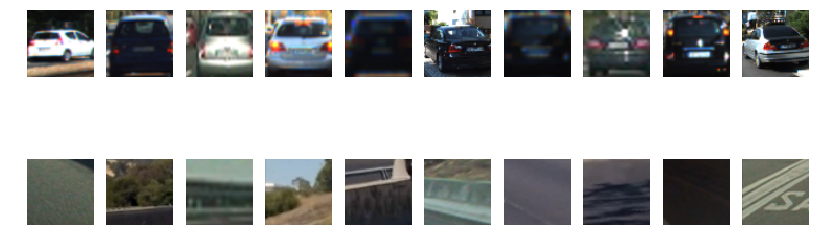

In [16]:
test_imgs = []
for rand in np.random.randint(10000,15000,size=10):
    test_imgs.append(cars_augment[rand])
for rand in np.random.randint(10000,15000,size=10):
    test_imgs.append(notcars_augment[rand])
N = len(test_imgs)
_ = plotList( test_imgs, shape=(2,int(N/2)), figsize=(14,5), plot_axis='off' )

In [21]:
t1 = time.time()

X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config_opt, cars_imgs, notcars_imgs)
#X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config_opt, cars_augment, notcars_augment)

print('extraction took {:.2f}s'.format(time.time()-t1))


t1 = time.time()

classifier, t_s = Classifier('nonlinear_svm').train(X_train, y_train)
train_acc = classifier.score(X_train, y_train)
test_acc  = classifier.score(X_test, y_test)
print('train accuracy = {:.2f}%, test accuracy = {:.2f}% ({} features)'.format(train_acc*100, test_acc*100, len(X_train[0])))

print('training took {:.2f}s'.format(time.time()-t1))

extraction took 30.21s
train accuracy = 98.75%, test accuracy = 98.37% (384 features)
training took 27.32s


---

# Sanity checks comments:

Note: Even after augmenting and retraining the classifier on a dataset of 15000 images it still does not pass my sanity checks with all three feature types. It's really annoying and weird.

When I use spatial features only, I achieve a train/test accuracy of around 97%. However, all sliding window locations always return a car detection...

When I use color histogram features only, I achieve a train/test accuracy of around 98%. However, it looks as tho I only receive false negatives as now sliding window ever gives a positive result.

When I use HoG features onlyI achieve a train/test accuracy of around 98%. The sanity checks start to make sense... Therefore I am going to disable color and spatial features then... Seriously, what's the point of them?

I'm finally giving up on finding good parameters. Looking at the video, the false positive rate is rather high and a lot of cars are not being detected.. I think this demonstrates a problem with the dataset, but moreover a problem with the approach chosen here for validation. Essentially we have a train/test split, but we have been making model choices based on our test data. This is normally done using a validation set in order to keep the test set completely independent. The final "testset" is the test images and the video, which ultimately do not work great.. So we must have made wrong decisions along the way, which have lead to overfitting to the test set and not generalize well to the video data.

---

---

---

# Here are some classifier sanity checks

[ 1.]


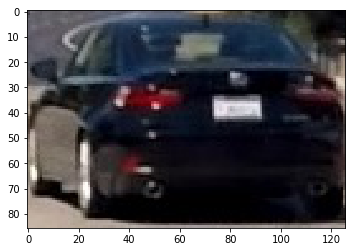

In [22]:
# I'm testing the (never seen before) black car in test1.jpg

from sliding_windows import slide_window, search_windows, draw_boxes, add_heat, apply_threshold, heatlabels, draw_labeled_bboxes, detect_raw, detect_labeled, find_cars

# test classifier on test image 1

test_image = mpimg.imread('test_images/test1.jpg')
window = ((816, 410), (942, 496))
crop = test_image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
plt.imshow(crop)
test = cv2.resize(crop, (64, 64))
test_features = extract_features([test], config_opt)
scaled_X = X_scaler.transform(test_features)
prediction = classifier.predict(scaled_X)
print(prediction)

The classifier should return 1 here.

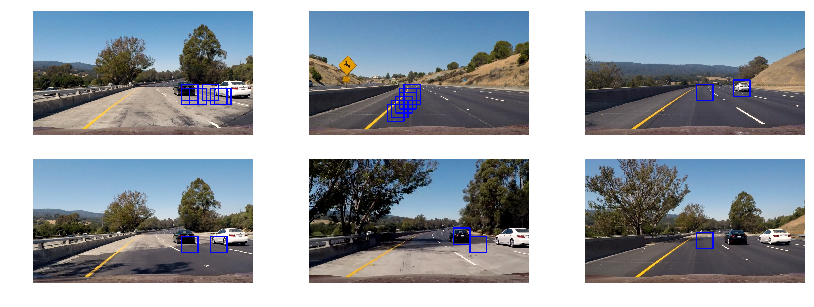

In [23]:
# 
test_images = glob.glob('test_images/*.jpg')
images = read_images(test_images)

windows = slide_window(
    images[0],
    x_start_stop = [None, None],
    y_start_stop = [400, 656],
    xy_window    =   (96, 96),
    xy_overlap   = (0.75, 0.75)
)


processed = []
for image in images:
    processed.append( detect_raw(image, windows, classifier, X_scaler, config_opt) )

N = len(processed)
_ = plotList( processed, shape=(2,int(N/2)), figsize=(14,5), plot_axis='off' )

At least a few reasonable car detections should be seen here. Ideally multiple windows around a single object and few false positives.

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

from functools import partial

try:
    os.mkdir('test_videos_output')
except:
    pass

def processVideo(name, out, f_process):
    video = VideoFileClip(name)
    video_clip = video.fl_image(f_process) #NOTE: this function expects color images!!
    %time video_clip.write_videofile(out, audio=False)

process = partial(detect_raw, windows=windows, classifier=classifier, X_scaler=X_scaler, config=config_opt)

processVideo("test_video.mp4", 'test_videos_output/test_video_sanity.mp4',process)
HTML("""
<video width="960" height="540" controls><source src="{0}"></video>
""".format('test_videos_output/test_video_sanity.mp4'))

[MoviePy] >>>> Building video test_videos_output/test_video_sanity.mp4
[MoviePy] Writing video test_videos_output/test_video_sanity.mp4



 97%|█████████▋| 38/39 [00:47<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video_sanity.mp4 

CPU times: user 46.8 s, sys: 336 ms, total: 47.2 s
Wall time: 48.2 s
